In [ ]:
import json
import os
import subprocess
import numpy as np
from treefarms import TREEFARMS

def construct_tree_rset(
    df,
    lam, db, eps,
    original_config_path='./config.json',
    save_dir=None,
    config_idx=None,
    verbose=False
    ):
    if verbose:
        print("save_dir: {}".format(save_dir))
        print("config_idx: {}".format(config_idx))

    with open(original_config_path) as f:
        configJson = json.load(f)
        configJson['depth_budget'] = db

        configJson['rashomon_bound_multiplier'] = 0
        configJson['rashomon_bound'] = 0
        configJson['rashomon_bound_adder'] = eps

        configJson['regularization'] = lam
        
        configJson['rashomon_trie'] = os.path.join(save_dir, 
                                        f'trie_bootstrap_{config_idx}_eps_{eps}_db_{db}_reg_{lam}.json')
        #configJson['rashomon_model_set_suffix'] = f'_bootstrap_{config_idx}_eps_{eps}_db_{db}_reg_{lam}.json'
        configJson['verbose'] = verbose

        tf = TREEFARMS(configJson)
    f.close()
    
    tf.fit(df.iloc[:, :-1], df.iloc[:, -1])

In [ ]:
import pandas as pd
df = pd.read_csv('fico_full.csv')

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=20, stratify=df['PoorRiskPerformance'])

In [ ]:
def binarize_and_split_according_to_train(train_df, test_df):
    thresholds = []
    for c in train_df.columns:
        if c == 'PoorRiskPerformance':
            continue
        # We should change this to not compute quantiles over negative values
        thresholds.append(train_df[c].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique())

    train_df_x = train_df.iloc[:, :-1]
    missingness_patterns = np.unique((train_df_x > 0), axis=0)
    missingness_datasets = []
    full_train = None
    for i in range(missingness_patterns.shape[0]): 
        cur_df = train_df[((train_df_x > 0) == missingness_patterns[i].reshape((1, -1)).repeat(train_df_x.shape[0], axis=0)).all(axis=1)]
        
        if missingness_patterns[i].mean() == 1:
            full_train = cur_df
        elif missingness_patterns[i].mean() == 0:
            continue
        else:
            missingness_datasets.append(cur_df)

    datasets = []
    for dataset in [full_train] + missingness_datasets + [test_df]:
        cur_dataset_binned = {}
        for i, c in enumerate(train_df.columns):
            if c == 'PoorRiskPerformance':
                continue
            for v in thresholds[i] + [-1]:
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(dataset.shape[0])
                new_row_train[dataset[c] <= v] = 1

                cur_dataset_binned[new_col_name] = new_row_train

        cur_dataset_binned['PoorRiskPerformance'] = dataset['PoorRiskPerformance']
        datasets.append(pd.DataFrame(cur_dataset_binned))

    return datasets[0], datasets[1:-1], datasets[-1]

In [ ]:
full_train, partial_trains, full_test = binarize_and_split_according_to_train(train_df, test_df)

In [ ]:
for i in partial_trains[0].columns:
    print(partial_trains[0][i].unique())

In [ ]:
import os
#os.makedirs('./experiments/datasets/fico/')
construct_tree_rset(
    full_train,
    0.05, 3, 0.05,
    original_config_path='./config.json',
    save_dir='./experiments/datasets/fico',
    config_idx='full',
    verbose=True
)

In [ ]:

for i, df in enumerate(partial_trains):
    construct_tree_rset(
        partial_trains[i],
        0.05, 3, 0.05,
        original_config_path='../Rashomon-Set-for-Trees/config.json',
        save_dir='./experiments/datasets/fico',
        config_idx=f'{i}',
        verbose=False
    )

In [ ]:
t1 = './experiments/datasets/fico/trie_bootstrap_full_eps_0.05_db_3_reg_0.05.json'
t2 = './experiments/datasets/fico/trie_bootstrap_5_eps_0.05_db_3_reg_0.05.json'

In [11]:
import json
from treefarms.model.model_set import ModelSetContainer
for i in [12]:
    t1 = './experiments/datasets/fico/trie_bootstrap_full_eps_0.05_db_3_reg_0.05.json'
    t2 = f'./experiments/datasets/fico/trie_bootstrap_{i}_eps_0.05_db_3_reg_0.05.json'
    with open(t1) as f1:
        with open(t2) as f2:
            trie_1 = json.load(f1)
            trie_2 = json.load(f2)

    print(i, trie_intersect_recursive(trie_1, trie_2))
    

12 {'9': {'21 -2': {'-2 -1': {'t1_loss': 0.25, 't2_loss': 0.0, 't1_complexity': 0.15000000596046448, 't2_complexity': 0.15000000596046448, 't1_objective': 0.4000000059604645, 't2_objective': 0.15000000596046448}}}, '21': {'-2 9': {'-1 -2': {'t1_loss': 0.25, 't2_loss': 0.0, 't1_complexity': 0.15000000596046448, 't2_complexity': 0.15000000596046448, 't1_objective': 0.4000000059604645, 't2_objective': 0.15000000596046448}}}}


In [ ]:
trie_2

In [ ]:
def trie_intersect_recursive(t1, t2):
    t1_keys = set(t1.keys())
    t2_keys = set(t2.keys())

    shared_keys = t1_keys.intersection(t2_keys)

    result = {}
    if 'loss' in shared_keys:
        for key in ['loss', 'complexity', 'objective']:
            result[f't1_{key}'] = t1[key]
            result[f't2_{key}'] = t2[key]
        return result

    for key in shared_keys:
        tmp_res = trie_intersect_recursive(t1[key], t2[key])

        # If there ar intersecting subtries
        if len(list(tmp_res.keys())) > 0:
            result[key] = tmp_res
        
    return result



In [ ]:

trie_intersect_recursive(trie_1, trie_2)

In [14]:
partial_trains[12].columns[[9, 21]]

Index(['ExternalRiskEstimate <= 93.0', 'AverageMInFile <= 65.0'], dtype='object')

<Axes: >

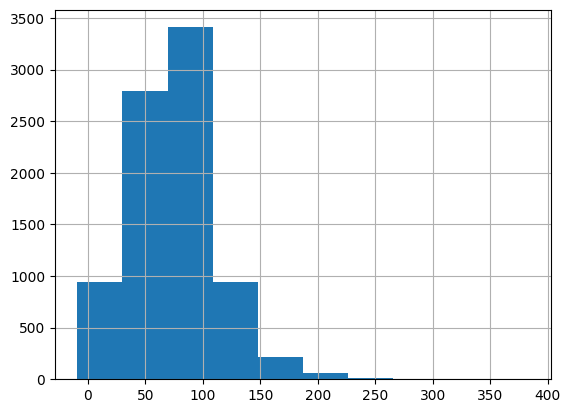

In [17]:
train_df['AverageMInFile'].hist()